# Inflation and contributions

In [1]:
from pynsee.macrodata.get_series_list import get_series_list
from pynsee.macrodata.get_series import get_series

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
import re

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

*Formula to compute contributions of each sub-item to the inflation index*:

$CTR_{m, k}^{a} = \frac{1}{I_{m, a-1}} [w_a^{k} \frac{I_{dec, a-1}}{I_{dec, a-1}^{k}} (I_{m, a-1}^{k} - I_{dec, a-1}^{k}) + w_{a-1}^{k} \frac{I_{dec, a-2}}{I_{dec, a-2}^{k}} (I_{dec, a-1}^{k} - I_{m, a-1}^{k})]$


* $k$ is the index of the sub-item, if it is not used the variable value corresponds to the agregated index
* $I$ is the index in nominal values
* $CTR_{m, a}^{k}$ contribution of sub-item k to the inflation index on year a and month m
* $w_a^{k}$ is the weight of the sub-item k in the agregated index for year a
* $m=dec$, december value is used

In [3]:
# from pynsee import init_conn
# init_conn(insee_key='key', insee_secret='secret')

In [4]:
# download a list of inflation dataset series identifiers
series = get_series_list('IPC-2015')

Existing environment variables used, instead of locally saved credentials


Getting datasets list: 100%|██████████| 201/201 [00:00<00:00, 1630.80it/s]

IPC-2015 : metadata update triggered because it is not found locally


Data saved: /home/onyxia/.cache/pynsee/pynsee/1877832c17b585d477598932d4295b9c


In [5]:
# total inflation series identifier
IdInflation = series.loc[(series.FREQ == "M") &
            (series.COICOP2016 == "00") &
            (series.NATURE == "INDICE") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO == "SO")]

# price indexes including in inflation total index
IdIndices = series.loc[(series.FREQ == "M") &
            (series.COICOP2016 == "SO") &
            (series.NATURE == "INDICE") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["4000", "4034", "4003", "4009", "4007"]))]

# weights of price indexes including in inflation total index
IdPond = series.loc[(series.FREQ == "A") &
            (series.COICOP2016 == "SO") &
            (series.NATURE == "POND") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["4000", "4034", "4003", "4009", "4007"]))]


In [6]:
# collect data
inflation = get_series(IdInflation.IDBANK)
indices = get_series(IdIndices.IDBANK)
pond = get_series(IdPond.IDBANK)

1/1 - Getting series: 100%|██████████| 5/5 [00:00<00:00, 43.81it/s]


In [7]:
# compute ponderation and annual growth rate
pond['pond'] = pond.OBS_VALUE / pond.groupby(['DATE']).OBS_VALUE.transform('sum')
indices['growth'] = (indices.OBS_VALUE/ indices.groupby(['IDBANK']).OBS_VALUE.shift(12) - 1) * 100
inflation['growth'] = (inflation.OBS_VALUE/ inflation.groupby(['IDBANK']).OBS_VALUE.shift(12) - 1) * 100

In [8]:
inflation['month'] = inflation['DATE'].apply(lambda x: x.month)
indices['month'] = indices['DATE'].apply(lambda x: x.month)

inflation['year'] = inflation['DATE'].apply(lambda x: x.year)
indices['year'] = indices['DATE'].apply(lambda x: x.year)
pond['year'] = pond['DATE'].apply(lambda x: x.year)

inflation = inflation.rename(columns = {"OBS_VALUE" : "inflation"})
indices = indices.rename(columns = {"OBS_VALUE" : "indices"})

inflationDec = inflation[inflation['month'] == 12]
indicesDec = indices[indices['month'] == 12]

indicesDec = indicesDec.rename(columns = {"indices" : "indicesDec"})
indicesDec = indicesDec[["year", "COICOP2016", "indicesDec", "PRIX_CONSO"]]

inflationDec = inflationDec.rename(columns = {"inflation" : "inflationDec"})
inflationDec = inflationDec[["year", "COICOP2016", "inflationDec", "PRIX_CONSO"]]

pond = pond[["year", "COICOP2016", "pond", "PRIX_CONSO"]]

In [9]:
# merge all datasets
data = indices.merge(indicesDec, on = ["year", "COICOP2016", "PRIX_CONSO"], how = 'left')
data = data.merge(pond, on = ["year", "COICOP2016", "PRIX_CONSO"], how = 'left')
data = data.merge(inflation[['DATE', 'inflation']], on = ["DATE"], how = 'left')
data = data.merge(inflationDec[['year', 'inflationDec']], on = ["year"], how = 'left')

In [10]:
# compute contributions by coicop
df = data.groupby(['month', 'COICOP2016', 'PRIX_CONSO'], as_index=False)

data['contrib1'] = df.apply(lambda x: x['inflationDec'].shift(1) * x['pond'] * 
                      (x['indices'] / x['indicesDec'].shift(1) - 1)).reset_index(level=0, drop=True)

data['contrib2'] = df.apply(lambda x: x['pond'].shift(1) * x['inflationDec'].shift(2) / x['indicesDec'].shift(2) *
                      (x['indicesDec'].shift(1) - x['indices'].shift(1))).reset_index(level=0, drop=True)

data['contrib'] =  df.apply(lambda x: 100 * (x['contrib1'] + x['contrib2']) /
                            x['inflation'].shift(1)).reset_index(level=0, drop=True)        

# reshape dataframe for plotting purposes
data2 = data[data['year'] >= 2008].sort_values(by="DATE").reset_index()
data2 = data2[['DATE', 'PRIX_CONSO_label_en', 'contrib']]
data2 = data2.pivot(index="DATE", columns="PRIX_CONSO_label_en", values="contrib")

In [11]:
# check that the sum of contribution is equal to annual growth rate of inflation
dfChecks = data.groupby(['DATE'], as_index=False)['contrib'].agg('sum')
dfChecks = dfChecks.merge(inflation[['DATE', 'growth']], on='DATE', how='left')
dfChecks = dfChecks[dfChecks['DATE'] >= "2008-01-01"].reset_index()

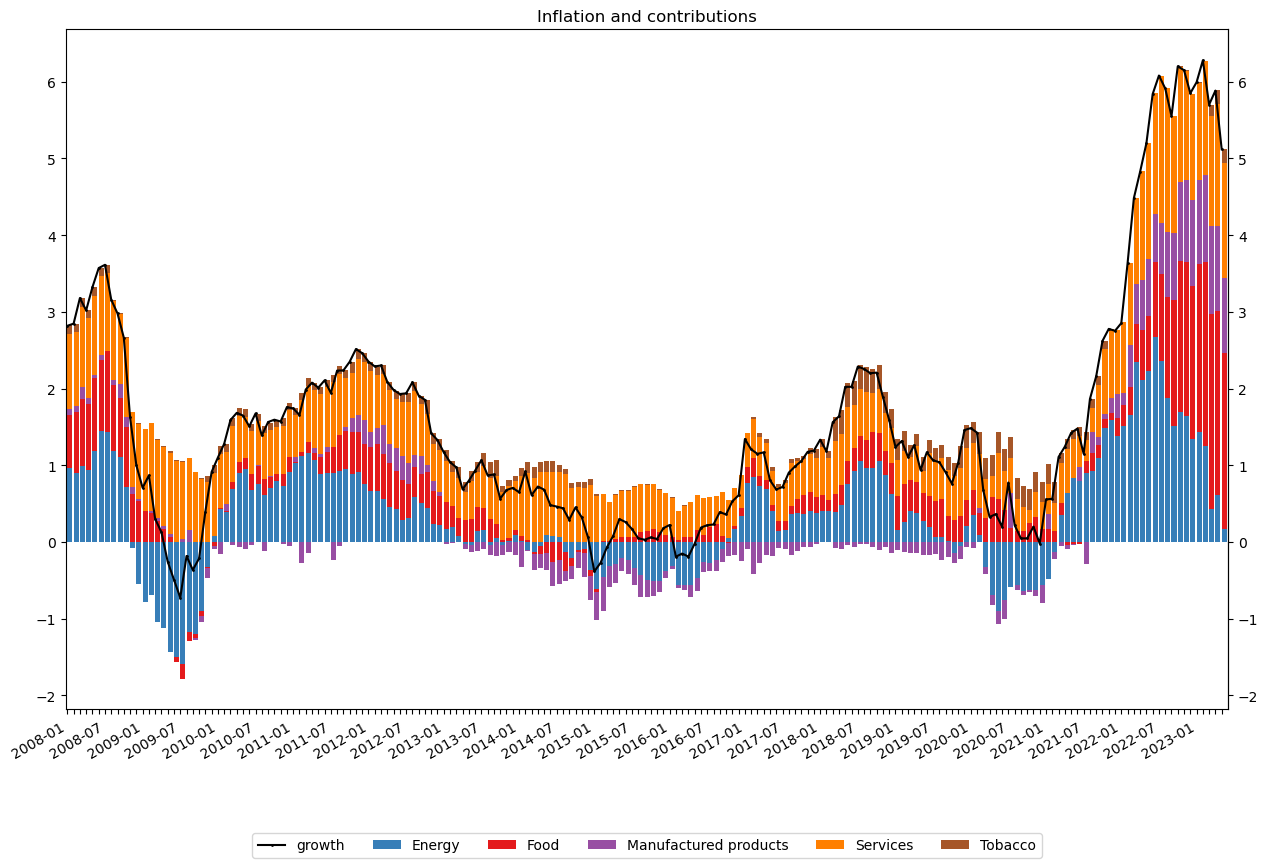

In [12]:
# make color palette
#colors = sns.color_palette("Set1") + sns.color_palette("Set2")

colors = [sns.color_palette("Set1")[1]] + \
        [c for i, c in enumerate(sns.color_palette("Set1")) if i not in [1, 2, 5]]

#
# draw plot
#

ax = data2.plot(kind='bar', stacked=True, align='edge', width=0.8,
                color=colors, figsize=(15,10))
#dfChecks.plot(ax=ax, y = "contrib", marker="x", color="b", markersize=1)
dfChecks.plot(ax=ax, y = "growth", marker="o", color="black", markersize=1)

#add title
plt.title("Inflation and contributions")

# customize x-axis tickers
time_period = [str(x)[:7] for x in data2.index]
ticklabels = ['']*len(data2.index)
ticklabels[::6] = [item for item in time_period[::6]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()
#remove legend
ax.get_legend().remove()
#remove x-axistitle
ax.xaxis.label.set_visible(False)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='center', ncol=len(data2.columns)+1)
ax.secondary_yaxis('right')
plt.show()

In [13]:
#
# Inflation, contributions with an energy focus
#

In [14]:
# total inflation series identifier
IdInflation = series.loc[(series.FREQ == "M") &
            (series.COICOP2016 == "00") &
            (series.NATURE == "INDICE") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO == "SO")]

# price indexes including in inflation total index
IdIndices = series.loc[(series.FREQ == "M") &
            (series.COICOP2016 == "SO") &
            (series.NATURE == "INDICE") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["4000", "4034", "4003", "4009"]))]

IdIndicesEnergy = series.loc[(series.FREQ == "M") &
            (series.COICOP2016.isin(["0452", "0451", "0453", "0454", "07221", "07222", "07223"])) &
            (series.NATURE == "INDICE") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["SO"]))]

IdIndices = pd.concat([IdIndices, IdIndicesEnergy])

# weights of price indexes including in inflation total index
IdPond = series.loc[(series.FREQ == "A") &
            (series.COICOP2016 == "SO") &
            (series.NATURE == "POND") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["4000", "4034", "4003", "4009"]))]

IdPondEnergy = series.loc[(series.FREQ == "A") &
            (series.COICOP2016.isin(["0452", "0451", "0453", "0454", "07221", "07222", "07223"])) &
            (series.NATURE == "POND") &
            (series.REF_AREA == "FE") &
            (series.MENAGES_IPC == "ENSEMBLE") &
            (series.PRIX_CONSO.isin(["SO"]))]


IdPond = pd.concat([IdPond, IdPondEnergy])

# collect data
inflation = get_series(IdInflation.IDBANK)
indices = get_series(IdIndices.IDBANK)
pond = get_series(IdPond.IDBANK)

# compute ponderation and annual growth rate
pond['pond'] = pond.OBS_VALUE / pond.groupby(['DATE']).OBS_VALUE.transform('sum')
indices['growth'] = (indices.OBS_VALUE/ indices.groupby(['IDBANK']).OBS_VALUE.shift(12) - 1) * 100
inflation['growth'] = (inflation.OBS_VALUE/ inflation.groupby(['IDBANK']).OBS_VALUE.shift(12) - 1) * 100

inflation['month'] = inflation['DATE'].apply(lambda x: x.month)
indices['month'] = indices['DATE'].apply(lambda x: x.month)

inflation['year'] = inflation['DATE'].apply(lambda x: x.year)
indices['year'] = indices['DATE'].apply(lambda x: x.year)
pond['year'] = pond['DATE'].apply(lambda x: x.year)

inflation = inflation.rename(columns = {"OBS_VALUE" : "inflation"})
indices = indices.rename(columns = {"OBS_VALUE" : "indices"})

inflationDec = inflation[inflation['month'] == 12]
indicesDec = indices[indices['month'] == 12]

indicesDec = indicesDec.rename(columns = {"indices" : "indicesDec"})
indicesDec = indicesDec[["year", "COICOP2016", "indicesDec", "PRIX_CONSO"]]

inflationDec = inflationDec.rename(columns = {"inflation" : "inflationDec"})
inflationDec = inflationDec[["year", "COICOP2016", "inflationDec", "PRIX_CONSO"]]

pond = pond[["year", "COICOP2016", "pond", "PRIX_CONSO"]]

# merge all datasets
data = indices.merge(indicesDec, on = ["year", "COICOP2016", "PRIX_CONSO"], how = 'left')
data = data.merge(pond, on = ["year", "COICOP2016", "PRIX_CONSO"], how = 'left')
data = data.merge(inflation[['DATE', 'inflation']], on = ["DATE"], how = 'left')
data = data.merge(inflationDec[['year', 'inflationDec']], on = ["year"], how = 'left')

# compute contributions by coicop
df = data.groupby(['month', 'COICOP2016', 'PRIX_CONSO'], as_index=False)

data['contrib1'] = df.apply(lambda x: x['inflationDec'].shift(1) * x['pond'] * 
                      (x['indices'] / x['indicesDec'].shift(1) - 1)).reset_index(level=0, drop=True)

data['contrib2'] = df.apply(lambda x: x['pond'].shift(1) * x['inflationDec'].shift(2) / x['indicesDec'].shift(2) *
                      (x['indicesDec'].shift(1) - x['indices'].shift(1))).reset_index(level=0, drop=True)

data['contrib'] =  df.apply(lambda x: 100 * (x['contrib1'] + x['contrib2']) /
                            x['inflation'].shift(1)).reset_index(level=0, drop=True)        


1/1 - Getting series: 100%|██████████| 11/11 [00:00<00:00, 49.74it/s]


In [15]:
def clean_string(x):
    return re.sub("\d|\.|\s|-", "", x)
    
data['COICOP2016_label_en'] = data['COICOP2016_label_en'].apply(lambda x: clean_string(x))

data['COICOP2016_label_en'] = np.where((data['COICOP2016'].isin(["0453", "0454", "07223"])),
                                       "other",      
                                       data['COICOP2016_label_en'])

data['PRIX_CONSO_label_en'] = np.where((data['PRIX_CONSO'] == "SO"),
                                       "Energy - " + data['COICOP2016_label_en'],      
                                       data['PRIX_CONSO_label_en'])


data2 = data.groupby(['DATE', "year",'PRIX_CONSO_label_en'], as_index=False).contrib.agg('sum')

# reshape dataframe for plotting purposes
data2 = data2[data2['year'] >= 2008].sort_values(by="DATE").reset_index()
data2 = data2[['DATE', 'PRIX_CONSO_label_en', 'contrib']]
data2 = data2.pivot(index="DATE", columns="PRIX_CONSO_label_en", values="contrib")
data2 = data2.dropna()

# check that the sum of contribution is equal to annual growth rate of inflation
dfChecks = data.groupby(['DATE'], as_index=False)['contrib'].agg('sum')
dfChecks = dfChecks.merge(inflation[['DATE', 'growth']], on='DATE', how='left')
dfChecks = dfChecks[dfChecks['DATE'] >= "2008-01-01"].reset_index()

In [16]:
# make color palette
colors = [c for i, c in enumerate(sns.color_palette("Blues")) if i in range(5)][::-1] + \
        [c for i, c in enumerate(sns.color_palette("Set1")) if i not in [1, 2, 5]]
       

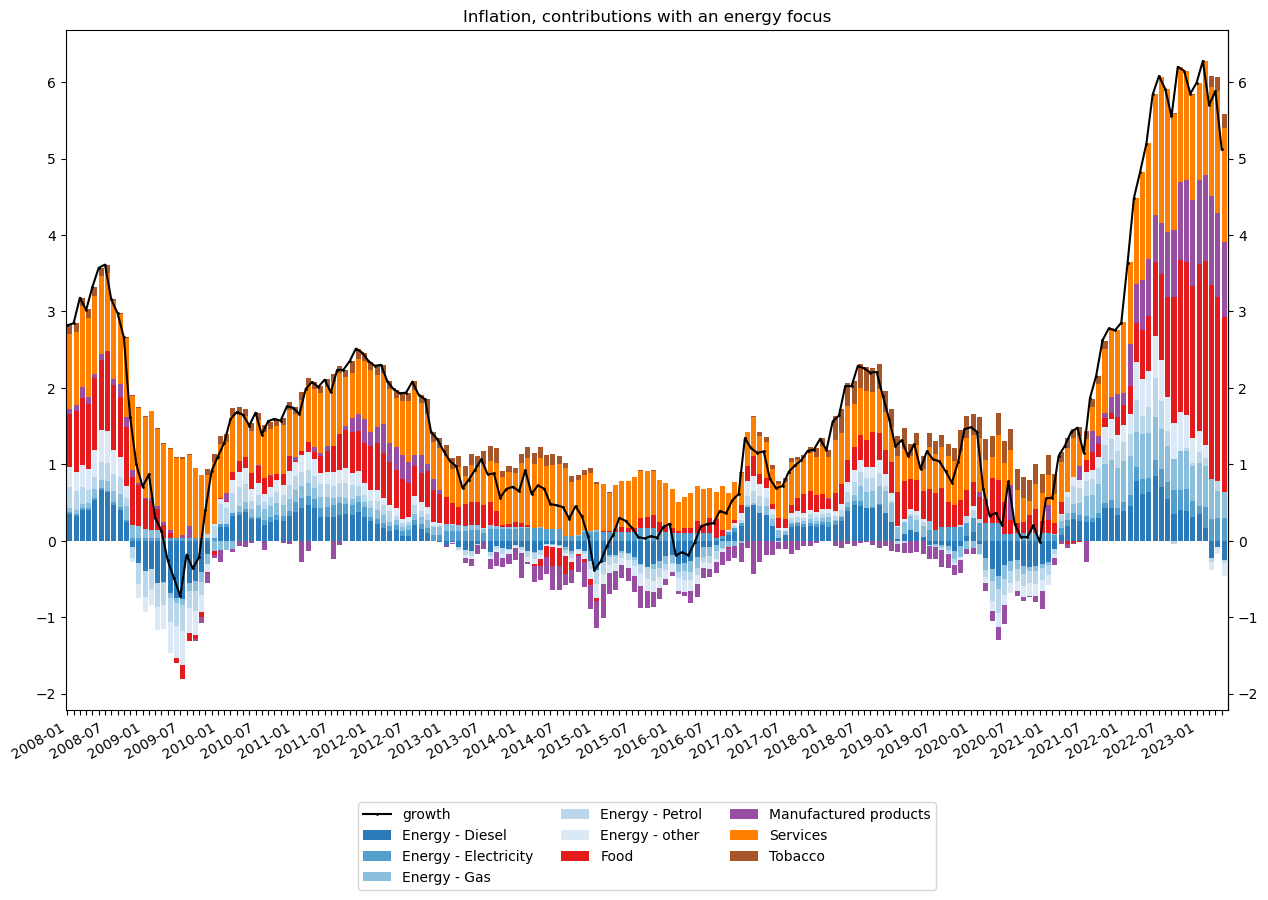

In [17]:

#
# draw plot
#

ax = data2.plot(kind='bar', stacked=True, align='edge', width=0.8,
                color=colors, figsize=(15,10))
#dfChecks.plot(ax=ax, y = "contrib", marker="x", color="b", markersize=1)
dfChecks.plot(ax=ax, y = "growth", marker="o", color="black", markersize=1)

#add title
plt.title("Inflation, contributions with an energy focus")

# customize x-axis tickers
time_period = [str(x)[:7] for x in data2.index]
ticklabels = ['']*len(data2.index)
ticklabels[::6] = [item for item in time_period[::6]]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
plt.gcf().autofmt_xdate()
#remove legend
ax.get_legend().remove()
#remove x-axistitle
ax.xaxis.label.set_visible(False)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='center', ncol=3)
ax.secondary_yaxis('right')
plt.show()